In [1]:
# Install required packages
!pip install accelerate
!pip install git+https://github.com/huggingface/transformers -q
!pip install torch torchaudio -q
!pip install seaborn-image
!pip install langdetect
!pip install -U deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import os
import time
import cv2
import tempfile
import numpy as np
import pandas as pd
import moviepy.editor as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as SklearnKMeans
from transformers import pipeline,BlipProcessor, BlipForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from langdetect import detect
import torch
from deep_translator import GoogleTranslator

# Initialize models
whisper = pipeline('automatic-speech-recognition', model='openai/whisper-tiny', device=0 if torch.cuda.is_available() else -1)
t5_model = T5ForConditionalGeneration.from_pretrained('cointegrated/rut5-base-absum')
t5_tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-base-absum')
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [3]:
#from deep_translator import GoogleTranslator
# Function to translate text using deep_translator library
def translate_text(text, src_lang='auto', dest_lang='ru'):
    try:
        translator = GoogleTranslator(source=src_lang, target=dest_lang)
        translated_text = translator.translate(text)
    except Exception as e:
        print(f"Translation error: {e}")
        translated_text = text  # Fallback to original text in case of an error
    return translated_text

# Function to transcribe audio segment from video
def transcribe_audio_segment(video_file_path, start_time, end_time):
    print("Loading video and extracting audio segment...")
    video = mp.VideoFileClip(video_file_path)
    video_segment = video.subclip(start_time, end_time)

    print("Writing audio segment to temporary file...")
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio_file:
        audio_path = temp_audio_file.name
        video_segment.audio.write_audiofile(audio_path, codec='pcm_s16le')

    print("Transcribing audio segment...")
    audio_text = whisper(audio_path)['text']

    # Clean up temporary audio file
    os.remove(audio_path)

    # Detect language of the transcribed text
    audio_language = detect(audio_text)

    return audio_text, audio_language


# Your text summarization function
def summarize_text_t5(text, max_length=100, num_beams=4, repetition_penalty=2.5):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    t5_model.to(device)
    input_ids = t5_tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True).to(device)

    with torch.no_grad():
        summary_ids = t5_model.generate(input_ids, max_length=max_length, num_beams=num_beams, repetition_penalty=repetition_penalty)

    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Your caption generation function
def generate_captions(frames, processor, model):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    captions = []
    for frame in frames:
        inputs = processor(frame, return_tensors="pt").to(device)
        with torch.no_grad():
            out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        captions.append(caption)
    return captions

# Your keyframe selection function
def select_keyframes_with_captions(video_path, clusters=5, num_keyframes=6):
    start_time = time.time()
    print("Loading video...")
    model_name = "Salesforce/blip-image-captioning-base"
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForConditionalGeneration.from_pretrained(model_name)
    reader = cv2.VideoCapture(video_path)

    frames = []
    frame_count = 0
    print("Reading frames...")
    while True:
        ret, frame = reader.read()
        if ret:
            if frame_count % 4 == 0:
                frames.append(frame)
            frame_count += 1
        else:
            break
    reader.release()

    print(f"Total frames read: {frame_count}")
    print(f"Total frames appended: {len(frames)}")

    if len(frames) == 0:
        print("No frames read from the video file. Exiting function.")
        return [], [], []

    print("Downsizing frames...")
    frames_downsized = [cv2.resize(frame, (frame.shape[1] // 4, frame.shape[0] // 4)) for frame in frames]
    frames_downsized = np.array(frames_downsized)
    frames_downsized_flattened = frames_downsized.reshape(frames_downsized.shape[0], -1)

    print("Applying PCA...")
    pca_start_time = time.time()
    pca = PCA(n_components=2)
    frames_2dim = pca.fit_transform(frames_downsized_flattened)
    print(f"PCA done in {time.time() - pca_start_time:.2f} seconds")

    print("Applying KMeans clustering...")
    kmeans_start_time = time.time()
    kmeans = SklearnKMeans(n_clusters=clusters, random_state=0)
    kmeans.fit(frames_2dim)
    print(f"KMeans clustering done in {time.time() - kmeans_start_time:.2f} seconds")

    labels = kmeans.labels_
    centroid_positions = kmeans.cluster_centers_

    print("Selecting keyframes...")
    label_frame_indices = []
    for i in range(clusters):
        input_data = frames_2dim[labels == i]
        input_indices = np.argwhere(labels == i)
        closest_index = np.argmin(np.abs(input_data - centroid_positions[i]).sum(axis=1))
        abs_index = input_indices[closest_index]
        label_frame_indices.append(abs_index[0])

    selected_frames = [frames[idx] for idx in label_frame_indices]
    selected_indices = label_frame_indices[:num_keyframes]

    print(f"Selected {len(selected_frames)} keyframes")

    print("Generating captions...")
    captions_start_time = time.time()
    selected_captions = generate_captions(selected_frames, processor, model)
    print(f"Captions generated in {time.time() - captions_start_time:.2f} seconds")

    print(f"Total keyframe selection and caption generation done in {time.time() - start_time:.2f} seconds")

    return selected_frames, selected_captions, selected_indices



In [14]:
# Main function to process the video
def main():
    video_path = input("Please enter the path to the video file: ")

    selected_frames, captions, frame_indices = select_keyframes_with_captions(video_path, num_keyframes=6)

    if len(selected_frames) == 0:
        print("No frames were selected. Exiting.")
        return None

    combined_texts = []
    timestamps = []
    intervals = []
    transcribed_texts = []
    image_captions = []

    for idx, frame_index in enumerate(frame_indices):
        timestamp = frame_index // 30  # Assuming video FPS is 30
        timestamps.append(f"{frame_index} ({timestamp}s)")

        start_time = max(0, timestamp - 10)  # Start 10 seconds before the timestamp
        end_time = timestamp + 10  # End 10 seconds after the timestamp

        audio_clip_text, audio_language = transcribe_audio_segment(video_path, start_time, end_time)
        transcribed_texts.append(audio_clip_text)

        # Translate the transcribed text to English if not already in English
        if audio_language != 'en':
            translation = translate_text(audio_clip_text, src_lang=audio_language, dest_lang='en')
            audio_clip_text = translation

        prompt = f"{captions[idx]} and {audio_clip_text}"
        summarized_text = summarize_text_t5(prompt)
        combined_texts.append(summarized_text)

        image_captions.append(captions[idx])

        interval = f"{start_time}-{end_time}"
        intervals.append(interval)

    df = pd.DataFrame({
        'Frame Number (Timestamp)': timestamps,
        'Interval (seconds)': intervals,
        'Transcribed Text': transcribed_texts,
        'Combined Text': combined_texts,
        'Image Caption': image_captions
    })

    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(selected_frames):
        plt.subplot(1, len(selected_frames), i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Keyframe {i + 1}')
    plt.show()

    return df


Please enter the path to the video file: /content/videoplayback.mp4
Loading video...
Reading frames...
Total frames read: 19155
Total frames appended: 4789
Downsizing frames...
Applying PCA...


  warnings.warn(



PCA done in 19.91 seconds
Applying KMeans clustering...
KMeans clustering done in 0.60 seconds
Selecting keyframes...
Selected 5 keyframes
Generating captions...


  warnings.warn(



Captions generated in 40.72 seconds
Total keyframe selection and caption generation done in 82.43 seconds
Loading video and extracting audio segment...
Writing audio segment to temporary file...
MoviePy - Writing audio in /tmp/tmpfh4cj6t4.wav


MoviePy - Done.
Transcribing audio segment...
Loading video and extracting audio segment...
Writing audio segment to temporary file...
MoviePy - Writing audio in /tmp/tmpkfbhq4vi.wav


MoviePy - Done.
Transcribing audio segment...
Loading video and extracting audio segment...
Writing audio segment to temporary file...
MoviePy - Writing audio in /tmp/tmpgtaqx04e.wav


MoviePy - Done.
Transcribing audio segment...
Loading video and extracting audio segment...
Writing audio segment to temporary file...
MoviePy - Writing audio in /tmp/tmphk8t4wp5.wav


MoviePy - Done.
Transcribing audio segment...
Loading video and extracting audio segment...
Writing audio segment to temporary file...
MoviePy - Writing audio in /tmp/tmps_0b_7ge.wav


MoviePy - Done.
Transcribing audio segment...


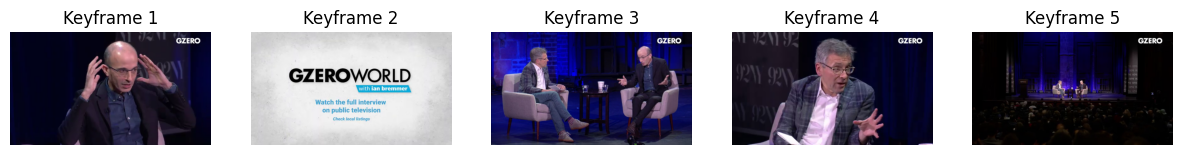

In [15]:
if __name__ == "__main__":
    df = main()
    if df is not None:
      df

In [16]:
df

,Frame Number (Timestamp),Interval (seconds),Transcribed Text,Combined Text,Image Caption
0,1433 (47s),37-57,being an atom bomb cannot decide who to bomb....,When a man in a suit and tie is sitting on a c...,a man in a suit and tie is sitting on a chair
1,4728 (157s),147-167,I hardly thought about AI at all. I mean in 2...,"When Benner was interviewed, I couldn't think ...",geworld with benner watch full interview
2,4183 (139s),129-149,the world will for the first time in history ...,These two men sitting in chairs talking on a s...,two men sitting in chairs talking on a stage
3,4416 (147s),137-157,actually faster than what you anticipated whe...,"When I wrote Sapiens in 2014, I hardly thought...",a man in a suit and tie sitting on a chair
4,3052 (101s),91-111,I think very soon we will reach a point when ...,When the stories that dominate the world ideol...,a man and woman sitting on a stage with a red ...
